In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint

from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
 

In [2]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [3]:

%matplotlib inline
from google.colab import files
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix 
print(tf.__version__)

2.9.2


In [4]:

imagepaths = []

for root, dirs, files in os.walk("mydrive/My Drive/DCGAN/", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): 
      imagepaths.append(path)

print(len(imagepaths)) 

1005


In [31]:
X = [] 
y = [] 


for path in imagepaths:
  img = cv2.imread(path) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  img = cv2.resize(img, (28, 28))
  X.append(img)
  

  category = path.split("/")[3]
  label = int(category.split(" ")[1]) 
  y.append(label)


X = np.array(X, dtype="uint8")
#X = X.reshape(len(imagepaths), 232, 424, 3) # 
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  1005
Labels loaded:  1005
4 mydrive/My Drive/DCGAN/Class 4/11.png


In [32]:
trainX, trainy=X,y
X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
X = X.astype('float32')
	# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5
print(X.shape, trainy.shape)



(1005, 28, 28, 1) (1005,)


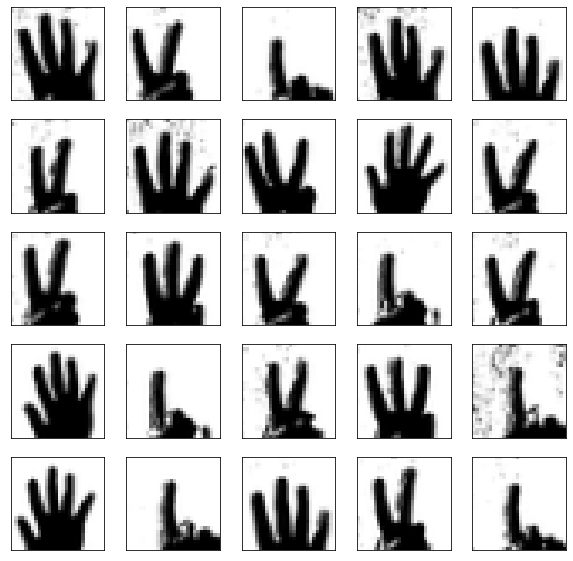

In [ ]:
# We plot first 25 images of training dataset
plt.figure(figsize =(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

In [33]:


def define_discriminator(in_shape=(28,28,1), n_classes=5):

	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 7x7
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	model = Model(in_image, [out1, out2])
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt, metrics=['binary_accuracy'])
	return model


In [34]:


def define_generator(latent_dim, n_classes=5):
	init = RandomNormal(stddev=0.02)
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = 7 * 7
	li = Dense(n_nodes, kernel_initializer=init)(li)
	li = Reshape((7, 7, 1))(li)
	in_lat = Input(shape=(latent_dim,))
	n_nodes = 384 * 7 * 7
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((7, 7, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	model = Model([in_lat, in_label], out_layer)
	return model


In [35]:

# ترکیب مولد و تفکیک کننده
def define_gan(g_model, d_model):
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt, metrics=['binary_accuracy'])
	return model


In [23]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y

In [24]:
def generate_latent_points(latent_dim, n_samples, n_classes=5):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]


In [25]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [26]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	X = (X + 1) / 2.0
	for i in range(100):

		pyplot.subplot(10, 10, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig("mydrive/My Drive/AC-gan/"+filename1)
	pyplot.close()
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save("mydrive/My Drive/AC-gan/"+filename2)
	print('>Saved: %s and %s' % (filename1, filename2))


In [36]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=64):
	d_loss=[]
	d_loss_labels=[]
	d_acc=[]
	g_loss=[]
	g_acc=[]
	d_acc_labels=[]
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	for i in range(n_steps):
		# get randomly selected 'real' samples
		[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
		# آموزش مدل تفکیک کننده با داده های واقعی
		_,d_r1,d_r2,d_acc_r1,d_acc_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# آموزش مدل تفکیک کننده با داده های فیک
		_,d_f,d_f2,d_acc_f1,d_acc_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		d_loss.append((d_f+d_r1)/2)
		d_loss_labels.append((d_f2+d_r2)/2)
		d_acc.append((d_acc_f1+d_acc_r1)/2)
		d_acc_labels.append((d_acc_f2+d_acc_r2)/2)
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		_,g_1,g_2,g_acc_r1,g_acc_r2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		g_loss.append((g_1+g_2)/2)
		g_acc.append((g_acc_r1+g_acc_r2)/2)
		# summarize loss on this batch
		
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 10) == 0:
			print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
			print(g_acc_r1,g_acc_r2)
			summarize_performance(i, g_model, latent_dim)
	return d_loss,d_loss_labels,d_acc,d_acc_labels,g_acc,g_loss




In [42]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = [X, trainy]
# train
d_loss,d_loss_labels,d_acc,d_acc_labels,g_acc,g_loss=train(generator, discriminator, gan_model, dataset, latent_dim)

1/1 [==============================] - 0s 16ms/step
>150, dr[0.186,0.090], df[0.031,0.333], g[0.117,0.186]
0.96875 0.16249999403953552
4/4 [==============================] - 0s 10ms/step


>Saved: generated_plot_0150.png and model_0150.h5
1/1 [==============================] - 0s 16ms/step
>300, dr[0.239,0.114], df[0.181,0.076], g[0.878,0.161]
0.53125 0.21562501788139343
4/4 [==============================] - 0s 10ms/step


>Saved: generated_plot_0300.png and model_0300.h5
1/1 [==============================] - 0s 16ms/step
>450, dr[1.137,0.091], df[0.733,0.207], g[1.421,0.080]
0.375 0.17812500894069672
4/4 [==============================] - 0s 9ms/step


>Saved: generated_plot_0450.png and model_0450.h5
1/1 [==============================] - 0s 13ms/step
>600, dr[0.550,0.055], df[0.963,0.262], g[1.977,0.050]
0.125 0.19374999403953552
4/4 [==============================] - 0s 10ms/step


>Saved: generated_plot_0600.png and model_0600.h5
1/1 [==============================] - 0s 16ms/step
>750, dr[0.688,0.025], df[0.519,0.049], g[1.709,0.081]
0.15625 0.19687500596046448
4/4 [==============================] - 0s 9ms/step


>Saved: generated_plot_0750.png and model_0750.h5


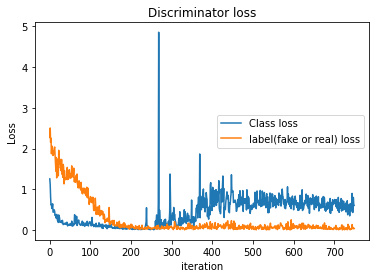

In [43]:
plt.plot(d_loss)
plt.plot(d_loss_labels)
plt.title('Discriminator loss')
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.legend(['Class loss', 'label(fake or real) loss'], loc='center right')
plt.show()

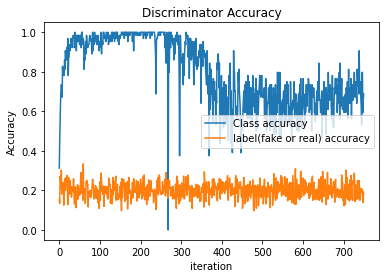

In [44]:
plt.plot(d_acc)
plt.plot(d_acc_labels)
plt.title('Discriminator Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('iteration')
plt.legend(['Class accuracy', 'label(fake or real) accuracy'], loc='center right')
plt.show()

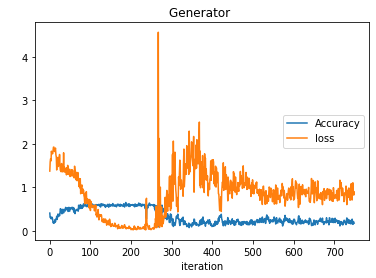

In [45]:
plt.plot(g_acc)
plt.plot(g_loss)
plt.title('Generator ')
plt.ylabel(' ')
plt.xlabel('iteration')
plt.legend(['Accuracy', 'loss'], loc='center right')
plt.show()